# Performance Analaysis of HEP codes (examples)

Authors: Brain Gravelle (gravelle@cs.uoregon.edu), Boyana Norris (norris@cs.uoregon.edu)


## 1. Prerequisites

These examples are based on the TAU and taucmdr tools from Paratools
http://taucommander.paratools.com/. Note that the analysis functionality is new and not yet publically available.

In [1]:
# A couple of scripts to set the environent and import data from a .tau set of results
from utilities import *
from metrics import *
# Plotting, notebook settings:
%matplotlib inline  
#plt.rcParams.update({'font.size': 16})
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.float_format', lambda x: '%.3e' % x)
pd.set_option('display.max_columns',300)

## 2. Performance data 

TAU Commander uses TAU to run the application and measure it using runtime sampling techniques (similar to Intel VTune). Many customization options are available. For example, we may consider each function regardless of calling context, or we may decide to enable callpath profiling to see each context separately.

Available experiments:
* multi - data based on a toy version of the program.
* realistic  - data based on a run of the program with the TT35PU... input file, 10 threads, and 100 events
* event_scaling_TT35  - data based on a run of the program with the TT35PU... input file, 10 threads, and events ranging from 10 to 100
* TT70  - data based on a run of the program with the TT70PU... input file, 10 threads, and 100 events
* event_scaling_TT35  - data based on a run of the program with the TT70PU... input file, 10 threads, and events ranging from 10 to 100
* note that the event scaling runs don't have a function to properly load the data yet

### Simple explorations

First, let's load the data from the current directory (in a .tau subdirectory created by TAU Commander). We also print the metadata for the performance experiment, which contains details about the execution environment.

In [4]:
expr_intervals = load_perf_data(application="mictest_sampling",experiment="realistic",nolibs=True)

#level_inds = {'trial': 0, 'rank': 1, 'context': 2, 'thread': 3, 'region': 4}
print(expr_intervals.keys())
print("\nColumns:\n")
print(expr_intervals['PAPI_TOT_CYC'].columns)
print("\nNames:\n")
print(expr_intervals['PAPI_TOT_CYC'].index.names)
print("\nMetadata:\n")
print_metadata(expr_intervals)

['PAPI_NATIVE_UOPS_RETIRED:SCALAR_SIMD', 'PAPI_L2_TCA', 'PAPI_NATIVE_LLC_MISSES', 'PAPI_RES_STL', 'PAPI_L2_TCM', 'PAPI_TOT_INS', 'PAPI_NATIVE_UOPS_RETIRED:PACKED_SIMD', 'PAPI_LST_INS', 'METADATA', 'PAPI_L1_TCM', 'PAPI_TOT_CYC', 'PAPI_NATIVE_LLC_REFERENCES']

Columns:

Index([u'Calls', u'Subcalls', u'Exclusive', u'Inclusive', u'ProfileCalls'], dtype='object')

Names:

[u'rank', u'context', u'thread', u'region']

Metadata:

TAU_MAX_THREADS                                    512
TAU_CUDA_BINARY_EXE                                None
TAU_MEASURE_TAU                                    off
Memory Size                                        115370324 kB
TAU_TRACK_SIGNALS                                  off
TAU_TRACK_IO_PARAMS                                off
CPU MHz                                            999.584
Local Time                                         2018-02-16T14:35:26-08:00
CPU Type                                           Intel(R) Xeon Phi(TM) CPU 7250 @ 1.40GHz
TAU_OU

Next, let's look at inclusive measurements of a hardware performance counter, e.g., PAPI_TOT_INS, sorted in decreasing order. As you can see, there are separate entries for each thread.

In [3]:
thread_cycles = filter_libs_out(expr_intervals['PAPI_TOT_CYC']).sort_values(by='Inclusive',ascending=False)[["Inclusive"]]
thread_cycles.head(100)

Inclusive
rank context thread region                                                        
0    0       0      [SUMMARY] _int_free                                 1231159555
                    [SUMMARY] _int_malloc                               1219269406
                    [SUMMARY] __GI___libc_malloc                        1202496560
                    [SUMMARY] Event::clean_cms_seedtracks()             1112271578
                    [SUMMARY] UNRESOLVED /storage/packages/intel/vt...   881792500
                    [SUMMARY] __intel_mic_avx512f_memset                 657456121
                    [SUMMARY] malloc_consolidate                         627882012
             2      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...   503503986
             8      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...   385617229
             0      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...   339042130
             8      [SUMMARY] __svml_sincosf8_l9                         332896727
             9      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...   331669849
             0      [SUMMARY] __GI___libc_free                           330621773
                    [SUMMARY] __read_nocancel                            327432072
             3      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...   305047428
             9      [SUMMARY] __svml_sincosf8_l9                         294167226
             7      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...   293533848
             0      [SUMMARY] __svml_sincosf8_l9                         286141040
             4      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...   280206265
             1      [SUMMARY] __svml_sincosf8_l9                         273108610
             0      [SUMMARY] __GI___sched_yield                         268625708
             1      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...   259743134
             2      [SUMMARY] __svml_sincosf8_l9                         251510670
             0      [SUMMARY] HitOnTrack::HitOnTrack()                   250575742
             5      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...   238641482
             0      [SUMMARY] __libm_atan2f_l9                           219755560
             3      [SUMMARY] __intel_mic_avx512f_memset                 209093573
             4      [SUMMARY] __svml_sincosf8_l9                         202777831
             6      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...   198731172
             0      [SUMMARY] void _INTERNAL_19_PropagationMPlex_cc...   188732223
...                                                                            ...
                    [SUMMARY] _ZNSt4pairIKiiEC1IIOiEILm0EEIEIEEERSt...    93769836
                    [SUMMARY] ROOT::Math::SVector<float, 6u>::SVect...    93165230
                    [SUMMARY] Track::zAtR(float, float*) const            91703528
             6      [SUMMARY] __intel_mic_avx512f_memset                  91398865
             0      [SUMMARY] Track::Track(Track const&)                  91177400
                    [SUMMARY] MkFinder::FindCandidatesCloneEngine(L...    90352006
             9      [SUMMARY] Matriplex::MatriplexSym<float, 6, 8>:...    87902803
             8      [SUMMARY] MkFinder::FindCandidatesCloneEngine(L...    86938280
             3      [SUMMARY] FMA(__m256 const&, __m256 const&, __m...    82514730
             5      [SUMMARY] (anonymous namespace)::MultHelixPropE...    79329001
             4      [SUMMARY] __GI___sched_yield                          77960385
             7      [SUMMARY] applyMaterialEffects(Matriplex::Matri...    77571912
             0      [SUMMARY] __libm_sse2_sincosf                         75683509
             8      [SUMMARY] __intel_mic_avx512f_memset                  75347765
             9      [SUMMARY] helixAtZ(Matriplex::Matriplex<float, ...    75316684
             6      [SUMMARY] __GI___sched_yield                          68819291
      

Now let us compute mean values for each function (considering all threads). This functionality is also available in utilities, so the same can be computed with `cycles = means(thread_cycles,inclusive=True, plot=True)` (the last two arguments are optional).

In [4]:
cycles = thread_cycles.groupby('region')['Inclusive'].sum().reset_index()
mean_cycles = cycles.groupby('region').mean().sort_values(by='Inclusive',ascending=False)
mean_cycles.head(100)

,Inclusive
region,
"[SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)",3135736523
[SUMMARY] __svml_sincosf8_l9,2181754990
[SUMMARY] __intel_mic_avx512f_memset,1616635754
[SUMMARY] _int_free,1231159555
[SUMMARY] _int_malloc,1230979310
[SUMMARY] __GI___libc_malloc,1204133900
[SUMMARY] Event::clean_cms_seedtracks(),1112271578
[SUMMARY] UNRESOLVED /storage/packages/intel/vtune_amplifier_xe_2017.5.0.526192/lib64/libstdc++.so.6.0.20,881792500
"[SUMMARY] MkFinder::FindCandidatesCloneEngine(LayerOfHits const&, CandCloner&, int, int, FindingFoos const&)",770923739


To show these values as percentages, we can scale by the total cycles.

In [5]:
percent_cycles = pd.DataFrame(mean_cycles['Inclusive']/thread_cycles['Inclusive'].sum())
percent_cycles.reset_index()
percent_cycles.style.format({'Inclusive': '{:,.2%}'.format})


,Inclusive
region,
"[SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)",11.79%
[SUMMARY] __svml_sincosf8_l9,8.20%
[SUMMARY] __intel_mic_avx512f_memset,6.08%
[SUMMARY] _int_free,4.63%
[SUMMARY] _int_malloc,4.63%
[SUMMARY] __GI___libc_malloc,4.53%
[SUMMARY] Event::clean_cms_seedtracks(),4.18%
[SUMMARY] UNRESOLVED /storage/packages/intel/vtune_amplifier_xe_2017.5.0.526192/lib64/libstdc++.so.6.0.20,3.32%
"[SUMMARY] MkFinder::FindCandidatesCloneEngine(LayerOfHits const&, CandCloner&, int, int, FindingFoos const&)",2.90%


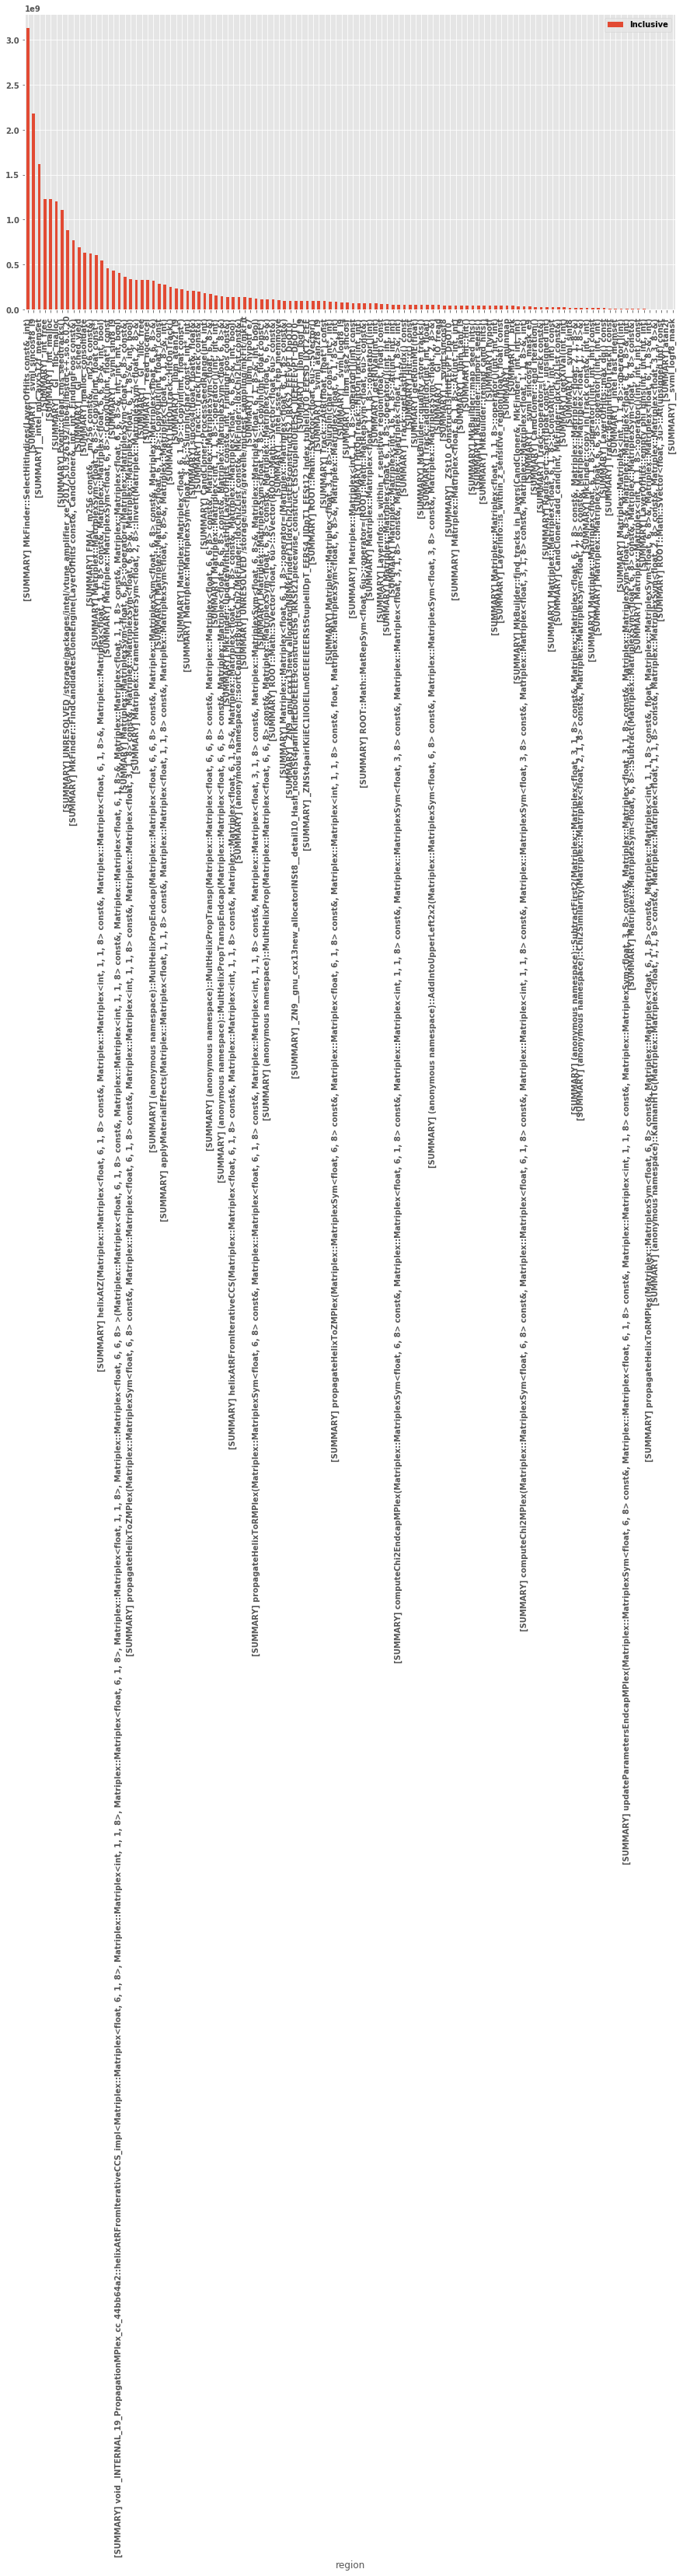

In [6]:
set_chart_font_size(10)
mean_cycles2 = means(thread_cycles,inclusive=True,plot=True)

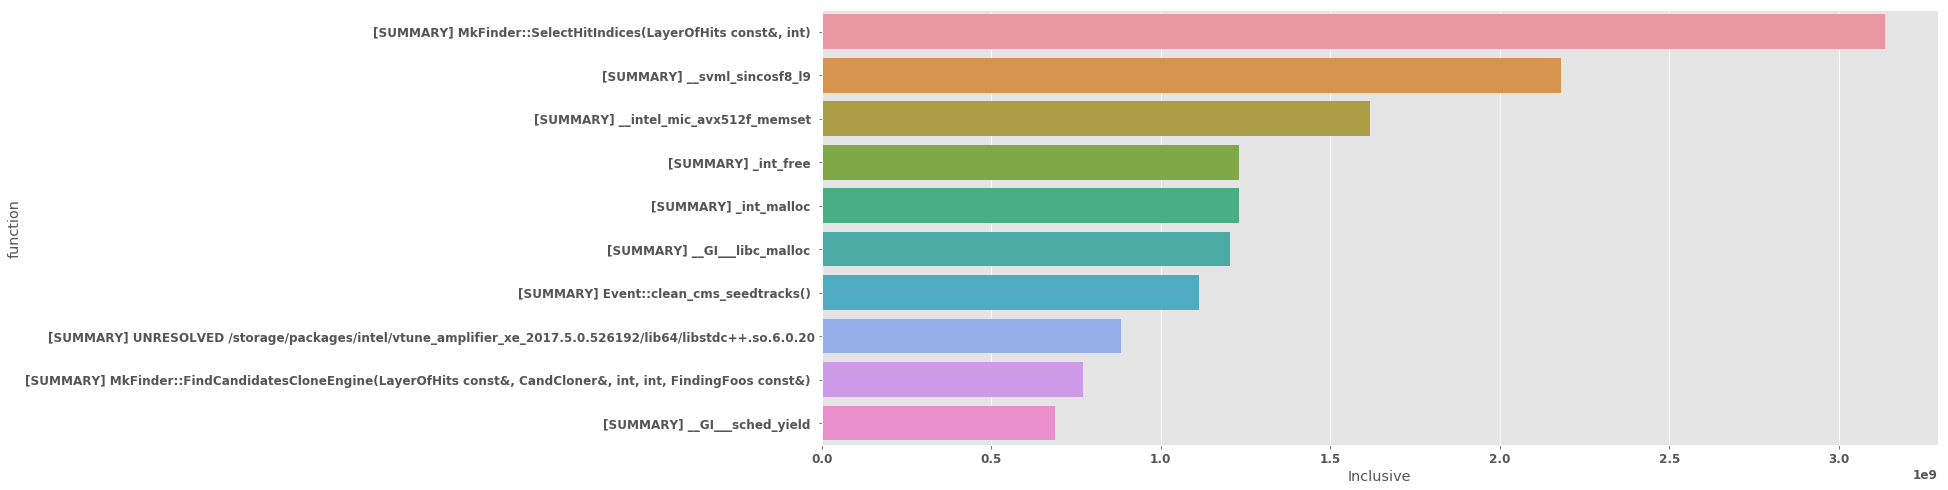

In [7]:
set_chart_font_size(12); plt.rcParams['figure.figsize']=(20,8)
mean_cycles2['function'] = mean_cycles2.index
g = sns.barplot(y='function',x='Inclusive',data=mean_cycles2.head(10))

### Another way to visualize function data

This is way too crowded, let's just look at the top functions. [Seaborn](https://tryolabs.com/blog/2017/03/16/pandas-seaborn-a-guide-to-handle-visualize-data-elegantly/) is great for making dataframe visualizations. Let's look at the top 10 functions in terms of mean cycles per thread.

### Standard deviations

Next we look at the standard deviations in thread cycle counts.

In [8]:
# First, all threads
all_cycles = expr_intervals['PAPI_TOT_CYC'].groupby(['thread','region'])['Inclusive'].sum().reset_index()
all_cycles.head(10)
#groupby(['thread']).head()

,thread,region,Inclusive
0,0,[SUMMARY] (anonymous namespace)::AddIntoUpperL...,48643072
1,0,[SUMMARY] (anonymous namespace)::MultHelixProp...,48571030
2,0,[SUMMARY] (anonymous namespace)::MultHelixProp...,47911531
3,0,[SUMMARY] (anonymous namespace)::MultHelixProp...,97190753
4,0,[SUMMARY] (anonymous namespace)::MultHelixProp...,97326458
5,0,[SUMMARY] (anonymous namespace)::sortCandListB...,48636195
6,0,"[SUMMARY] CandCloner::ProcessSeedRange(int, int)",93850709
7,0,[SUMMARY] Event::clean_cms_seedtracks(),1112271578
8,0,"[SUMMARY] FMA(__m256 const&, __m256 const&, __...",142228140
9,0,[SUMMARY] Hit::Hit(),45798584


Thread 0 is clearly doing a lot of work that the others don't (to be expected with TBB), so it's more productive to focus on the remaining 9 threads. Per-thread cycle counts can then be obtained with:

In [9]:
all_cycles = all_cycles[all_cycles.thread != 0]  # exclude thread 0
all_cycles.groupby('thread').sum()

,Inclusive
thread,
1,1718893606
2,1628926827
3,1269509422
4,1628330416
5,1595236588
6,1340826513
7,1435736879
8,1636899642
9,1363135841


In [10]:
cycles_per_thread = all_cycles.groupby('thread').sum()
print(cycles_per_thread.head(10))
cycles_std = cycles_per_thread['Inclusive'].std()
print("Standard deviation over threads: %g"%cycles_std)

         Inclusive
thread            
1       1718893606
2       1628926827
3       1269509422
4       1628330416
5       1595236588
6       1340826513
7       1435736879
8       1636899642
9       1363135841
Standard deviation over threads: 1.6148e+08


So what is thread 0 doing that the others are not? Let's take a look:

In [11]:
thread_0 = expr_intervals['PAPI_TOT_CYC'].xs(0, level='thread').sort_values(by='Inclusive',ascending=False,axis=0)
thread_0.head(20)

Calls  \
rank context region                                                      
0    0       [SUMMARY] _int_free                                    26   
             [SUMMARY] _int_malloc                                  27   
             [SUMMARY] __GI___libc_malloc                           26   
             [SUMMARY] Event::clean_cms_seedtracks()                25   
             [SUMMARY] UNRESOLVED /storage/packages/intel/vt...     19   
             [SUMMARY] __intel_mic_avx512f_memset                   14   
             [SUMMARY] malloc_consolidate                           13   
             [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...      7   
             [SUMMARY] __GI___libc_free                              7   
             [SUMMARY] __read_nocancel                               7   
             [SUMMARY] __svml_sincosf8_l9                            6   
             [SUMMARY] __GI___sched_yield                            6   
             [SUMMARY] HitOnTrack::HitOnTrack()                      6   
             [SUMMARY] __libm_atan2f_l9                              5   
             [SUMMARY] void _INTERNAL_19_PropagationMPlex_cc...      4   
             [SUMMARY] sincos4(float, float&, float&)                3   
             [SUMMARY] Matriplex::Matriplex<float, 6, 1, 8>:...      3   
             [SUMMARY] FMA(__m256 const&, __m256 const&, __m...      3   
             [SUMMARY] Matriplex::MatriplexSym<float, 6, 8>:...      3   
             [SUMMARY] UNRESOLVED /storage/users/gravelle/mi...      3   

                                                                 Subcalls  \
rank context region                                                         
0    0       [SUMMARY] _int_free                                        0   
             [SUMMARY] _int_malloc                                      0   
             [SUMMARY] __GI___libc_malloc                               0   
             [SUMMARY] Event::clean_cms_seedtracks()                    0   
             [SUMMARY] UNRESOLVED /storage/packages/intel/vt...         0   
             [SUMMARY] __intel_mic_avx512f_memset                       0   
             [SUMMARY] malloc_consolidate                               0   
             [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...         0   
             [SUMMARY] __GI___libc_free                                 0   
             [SUMMARY] __read_nocancel                                  0   
             [SUMMARY] __svml_sincosf8_l9                               0   
             [SUMMARY] __GI___sched_yield                               0   
             [SUMMARY] HitOnTrack::HitOnTrack()                         0   
             [SUMMARY] __libm_atan2f_l9                                 0   
             [SUMMARY] void _INTERNAL_19_PropagationMPlex_cc...         0   
             [SUMMARY] sincos4(float, float&, float&)                   0   
             [SUMMARY] Matriplex::Matriplex<float, 6, 1, 8>:...         0   
             [SUMMARY] FMA(__m256 const&, __m256 const&, __m...         0   
             [SUMMARY] Matriplex::MatriplexSym<float, 6, 8>:...         0   
             [SUMMARY] UNRESOLVED /storage/users/gravelle/mi...         0   

                                                                  Exclusive  \
rank context region                                                           
0    0       [SUMMARY] _int_free                                 1231159555   
             [SUMMARY] _int_malloc                               1219269406   
             [SUMMARY] __GI___libc_malloc                        1202496560   
             [SUMMARY] Event::clean_cms_seedtracks()             1112271578   
             [SUMMARY] UNRESOLVED /storage/packages/intel/vt...   881792500   
             [SUMMARY] __intel_mic_avx512f_memset                 657456121   
             [SUMMARY] malloc_consolidate                         627882012   
             [SUMMARY] MkFinde

In [12]:
thread_1 = expr_intervals['PAPI_TOT_CYC'].xs(1, level='thread').sort_values(by='Inclusive',ascending=False,axis=0)
thread_1.head(20)

Calls  \
rank context region                                                      
0    0       [SUMMARY] __svml_sincosf8_l9                           11   
             [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...     13   
             [SUMMARY] __intel_mic_avx512f_memset                    6   
             [SUMMARY] Matriplex::MatriplexSym<float, 6, 8>:...      5   
             [SUMMARY] propagateHelixToZMPlex(Matriplex::Mat...      3   
             [SUMMARY] MkFinder::FindCandidatesCloneEngine(L...      3   
             [SUMMARY] helixAtZ(Matriplex::Matriplex<float, ...      2   
             [SUMMARY] Matriplex::MatriplexSym<float, 6, 8>:...      2   
             [SUMMARY] FMA(__m256 const&, __m256 const&, __m...      2   
             [SUMMARY] void _INTERNAL_19_PropagationMPlex_cc...      1   
             [SUMMARY] helixAtRFromIterativeCCS(Matriplex::M...      1   
             [SUMMARY] __svml_sinf8_l9                               1   
             [SUMMARY] Track::Track(Track const&)                    1   
             [SUMMARY] Matriplex::Matriplex<float, 6, 1, 8>:...      1   
             [SUMMARY] Matriplex::Matriplex<float, 6, 1, 8>:...      1   
             [SUMMARY] applyMaterialEffects(Matriplex::Matri...      1   
             [SUMMARY] (anonymous namespace)::MultHelixPropT...      1   
             [SUMMARY] CandCloner::ProcessSeedRange(int, int)        1   
             [SUMMARY] Matriplex::MatriplexSym<float, 6, 8>:...      1   
             [SUMMARY] Matriplex::Matriplex<float, 6, 1, 8>:...      1   

                                                                 Subcalls  \
rank context region                                                         
0    0       [SUMMARY] __svml_sincosf8_l9                               0   
             [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...         0   
             [SUMMARY] __intel_mic_avx512f_memset                       0   
             [SUMMARY] Matriplex::MatriplexSym<float, 6, 8>:...         0   
             [SUMMARY] propagateHelixToZMPlex(Matriplex::Mat...         0   
             [SUMMARY] MkFinder::FindCandidatesCloneEngine(L...         0   
             [SUMMARY] helixAtZ(Matriplex::Matriplex<float, ...         0   
             [SUMMARY] Matriplex::MatriplexSym<float, 6, 8>:...         0   
             [SUMMARY] FMA(__m256 const&, __m256 const&, __m...         0   
             [SUMMARY] void _INTERNAL_19_PropagationMPlex_cc...         0   
             [SUMMARY] helixAtRFromIterativeCCS(Matriplex::M...         0   
             [SUMMARY] __svml_sinf8_l9                                  0   
             [SUMMARY] Track::Track(Track const&)                       0   
             [SUMMARY] Matriplex::Matriplex<float, 6, 1, 8>:...         0   
             [SUMMARY] Matriplex::Matriplex<float, 6, 1, 8>:...         0   
             [SUMMARY] applyMaterialEffects(Matriplex::Matri...         0   
             [SUMMARY] (anonymous namespace)::MultHelixPropT...         0   
             [SUMMARY] CandCloner::ProcessSeedRange(int, int)           0   
             [SUMMARY] Matriplex::MatriplexSym<float, 6, 8>:...         0   
             [SUMMARY] Matriplex::Matriplex<float, 6, 1, 8>:...         0   

                                                                 Exclusive  \
rank context region                                                          
0    0       [SUMMARY] __svml_sincosf8_l9                        273108610   
             [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  259743134   
             [SUMMARY] __intel_mic_avx512f_memset                168311060   
             [SUMMARY] Matriplex::MatriplexSym<float, 6, 8>:...  138673021   
             [SUMMARY] propagateHelixToZMPlex(Matriplex::Mat...  115657489   
             [SUMMARY] MkFinder::FindCandidatesCloneEngine(L...   95448018   
             [SUMMARY] helixAtZ(Matriplex::Matriplex<float, ...   68195127   
             [SUMMARY] Matriplex::Matri

In [13]:
thread_0_and_1 =  pd.concat([thread_0.reset_index(drop=0).add_suffix('_0'),
            thread_1.reset_index(drop=0).add_suffix('_1')], axis=1).fillna('')
thread_0_and_1[['region_0','Inclusive_0','Inclusive_1','region_1']].head(20)

,region_0,Inclusive_0,Inclusive_1,region_1
0,[SUMMARY] _int_free,1231159555,2.731e+08,[SUMMARY] __svml_sincosf8_l9
1,[SUMMARY] _int_malloc,1219269406,2.597e+08,[SUMMARY] MkFinder::SelectHitIndices(LayerOfHi...
2,[SUMMARY] __GI___libc_malloc,1202496560,1.683e+08,[SUMMARY] __intel_mic_avx512f_memset
3,[SUMMARY] Event::clean_cms_seedtracks(),1112271578,1.387e+08,"[SUMMARY] Matriplex::MatriplexSym<float, 6, 8>..."
4,[SUMMARY] UNRESOLVED /storage/packages/intel/v...,881792500,1.157e+08,[SUMMARY] propagateHelixToZMPlex(Matriplex::Ma...
5,[SUMMARY] __intel_mic_avx512f_memset,657456121,9.545e+07,[SUMMARY] MkFinder::FindCandidatesCloneEngine(...
6,[SUMMARY] malloc_consolidate,627882012,6.820e+07,"[SUMMARY] helixAtZ(Matriplex::Matriplex<float,..."
7,[SUMMARY] MkFinder::SelectHitIndices(LayerOfHi...,339042130,6.523e+07,"[SUMMARY] Matriplex::MatriplexSym<float, 6, 8>..."
8,[SUMMARY] __GI___libc_free,330621773,5.727e+07,"[SUMMARY] FMA(__m256 const&, __m256 const&, __..."
9,[SUMMARY] __read_nocancel,327432072,4.347e+07,[SUMMARY] void _INTERNAL_19_PropagationMPlex_c...


### Variance
Similarly, we can compute the variance in cycles per thread (all functions).

        Inclusive
thread           
0       8.543e+16
1       4.579e+15
2       1.038e+16
3       4.492e+15
4       4.192e+15
5       2.581e+15
6       2.293e+15
7       3.951e+15
8       6.906e+15
9       5.365e+15


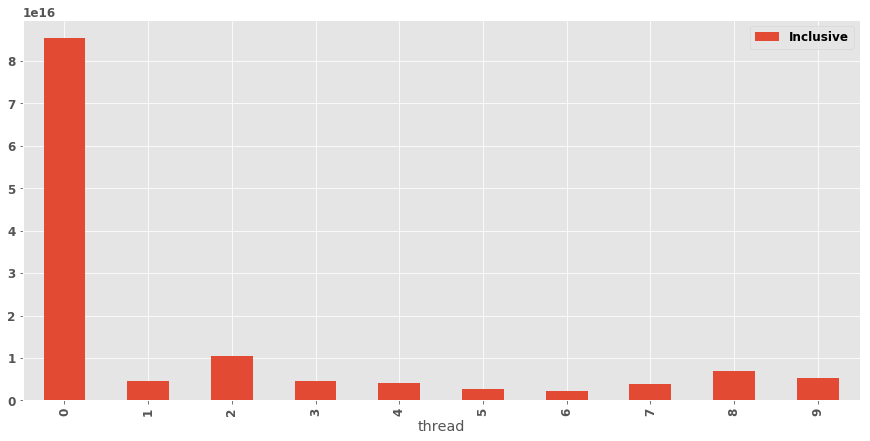

In [14]:
cycles_var = thread_variance(expr_intervals['PAPI_TOT_CYC'],inclusive=True,sort=False,plot=True)
print(cycles_var.head(10))

## 2. Single function details

We can also focus on a specific function and explore its performance. First, let's look at a single metric, total cycles again. Suppose we want to only see the data for function `MkFinder::SelectHitIndices`. Multiple functions can be included by separating them with "|", e.g., `MkFinder::SelectHitIndices|MatriplexSym`.

In [15]:
all_cycles = expr_intervals['PAPI_TOT_CYC']
all_cycles[all_cycles.index.get_level_values('region').str.contains("MkFinder::SelectHitIndices")]

Calls  \
rank context thread region                                                      
0    0       0      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...      7   
             1      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...     13   
             2      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...     17   
             3      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...      9   
             4      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...      9   
             5      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...      9   
             6      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...      9   
             7      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...     13   
             8      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...     15   
             9      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...     15   

                                                                        Subcalls  \
rank context thread region                                                         
0    0       0      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...         0   
             1      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...         0   
             2      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...         0   
             3      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...         0   
             4      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...         0   
             5      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...         0   
             6      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...         0   
             7      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...         0   
             8      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...         0   
             9      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...         0   

                                                                        Exclusive  \
rank context thread region                                                          
0    0       0      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  339042130   
             1      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  259743134   
             2      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  503503986   
             3      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  305047428   
             4      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  280206265   
             5      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  238641482   
             6      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  198731172   
             7      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  293533848   
             8      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  385617229   
             9      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  331669849   

                                                                        Inclusive  \
rank context thread region                                                          
0    0       0      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  339042130   
             1      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  259743134   
             2      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  503503986   
             3      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  305047428   
             4      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  280206265   
             5      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  238641482   
             6      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  198731172   
             7      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  293533848   
             8      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  385617229   
             9      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  331669849   

                                                

## 3. Adding metrics

Next, let us explore this function's performance using some derived metrics. These are defined in metrics.py; new metrics can be added there or in the notebook (initially it's easier to add to the notebook).

In [16]:
add_IPC(expr_intervals)
ipc = expr_intervals['DERIVED_IPC']
ipc_fun = ipc[ipc.index.get_level_values('region').str.contains("MkFinder::SelectHitIndices")]
ipc_fun.head(100)

Calls  \
context thread region                                                         
0       0      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit... 2.714e+00   
        1      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit... 1.000e+00   
        2      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit... 5.294e-01   
        3      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit... 6.667e-01   
        4      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit... 1.333e+00   
        5      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit... 1.556e+00   
        6      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit... 1.111e+00   
        7      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit... 8.462e-01   
        8      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit... 5.333e-01   
        9      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit... 5.333e-01   

                                                                   Exclusive  \
context thread region                                                          
0       0      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1.659e+00   
        1      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  5.308e-01   
        2      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  3.255e-01   
        3      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  3.929e-01   
        4      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  7.977e-01   
        5      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  8.060e-01   
        6      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  6.095e-01   
        7      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  5.115e-01   
        8      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  2.181e-01   
        9      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  3.823e-01   

                                                                   Inclusive  \
context thread region                                                          
0       0      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1.659e+00   
        1      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  5.308e-01   
        2      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  3.255e-01   
        3      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  3.929e-01   
        4      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  7.977e-01   
        5      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  8.060e-01   
        6      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  6.095e-01   
        7      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  5.115e-01   
        8      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  2.181e-01   
        9      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  3.823e-01   

                                                                   ProfileCalls  \
context thread region                                                             
0       0      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...           nan   
        1      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...           nan   
        2      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...           nan   
        3      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...           nan   
        4      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...           nan   
        5      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...           nan   
        6      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...           nan   
        7      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...           nan   
        8      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...           nan   
        9      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...           nan   

                                                                   Subcalls  
context thread region                                                        
0       0      [SUMMARY] MkFinder::SelectHitIn

In [17]:
add_VIPC(expr_intervals)
vipc = expr_intervals['DERIVED_VIPC']
vipc_fun = vipc.loc[vipc.index.get_level_values('region').str.contains("MkFinder::SelectHitIndices")].copy()
vipc_fun.head(10)

Calls  \
context thread region                                                         
0       0      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit... 2.429e+00   
        1      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit... 1.077e+00   
        2      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit... 7.647e-01   
        3      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit... 1.778e+00   
        4      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit... 1.000e+00   
        5      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit... 1.111e+00   
        6      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit... 1.111e+00   
        7      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit... 1.000e+00   
        8      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit... 4.667e-01   
        9      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit... 5.333e-01   

                                                                   Exclusive  \
context thread region                                                          
0       0      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  2.857e-01   
        1      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  2.040e-01   
        2      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1.210e-01   
        3      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1.248e-01   
        4      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1.008e-01   
        5      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  2.128e-01   
        6      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  2.058e-01   
        7      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  2.508e-01   
        8      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  5.718e-02   
        9      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1.189e-01   

                                                                   Inclusive  \
context thread region                                                          
0       0      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  2.857e-01   
        1      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  2.040e-01   
        2      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1.210e-01   
        3      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1.248e-01   
        4      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1.008e-01   
        5      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  2.128e-01   
        6      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  2.058e-01   
        7      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  2.508e-01   
        8      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  5.718e-02   
        9      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...  1.189e-01   

                                                                   ProfileCalls  \
context thread region                                                             
0       0      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...           nan   
        1      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...           nan   
        2      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...           nan   
        3      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...           nan   
        4      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...           nan   
        5      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...           nan   
        6      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...           nan   
        7      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...           nan   
        8      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...           nan   
        9      [SUMMARY] MkFinder::SelectHitIndices(LayerOfHit...           nan   

                                                                   Subcalls  
context thread region                                                        
0       0      [SUMMARY] MkFinder::SelectHitIn

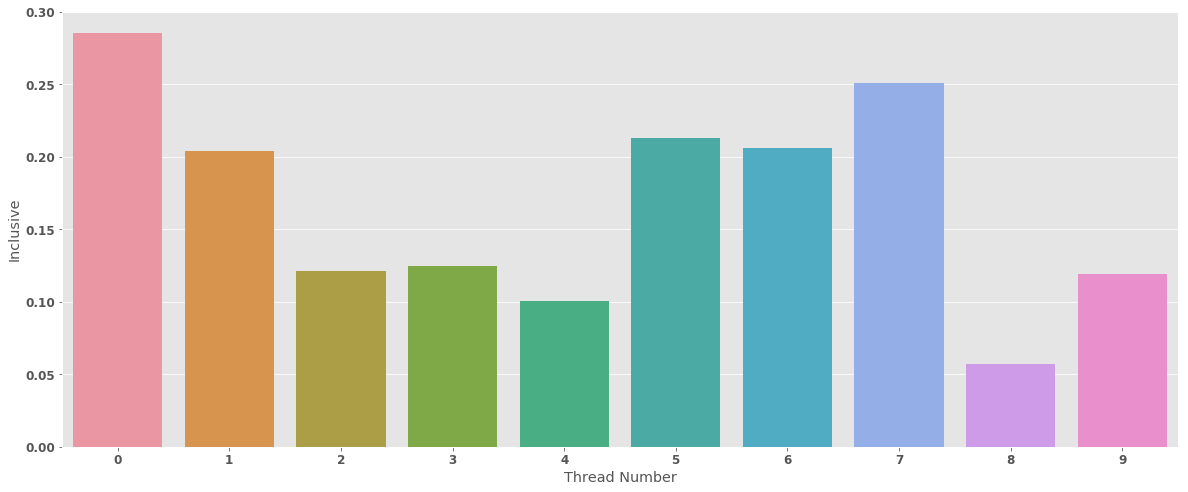

In [18]:
vipc_fun['Thread Number'] = vipc_fun.index.get_level_values('thread')
vipc_fun.head(10)
g = sns.barplot(x='Thread Number',y='Inclusive',data=vipc_fun)

The same can be accomplished by using the ``plot_metric`` function implemented in metrics.py. An example invocation is shown below. The function returns two values, the resulting (copied) dataframe containing only data for the specified function and the handle to the generated Seaborn plot (for further formatting). If no function is specified, the data for all functions is shown per thread.

context  thread  region                                                        
0        0       [SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)    1.770e-02
         1       [SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)    2.504e-02
         2       [SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)    3.718e-02
         3       [SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)    9.557e-03
         4       [SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)    1.847e-02
         5       [SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)    1.057e-02
         6       [SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)    1.076e-01
         7       [SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)    1.128e-02
         8       [SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)    1.863e-02
         9       [SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)    9.555e-03


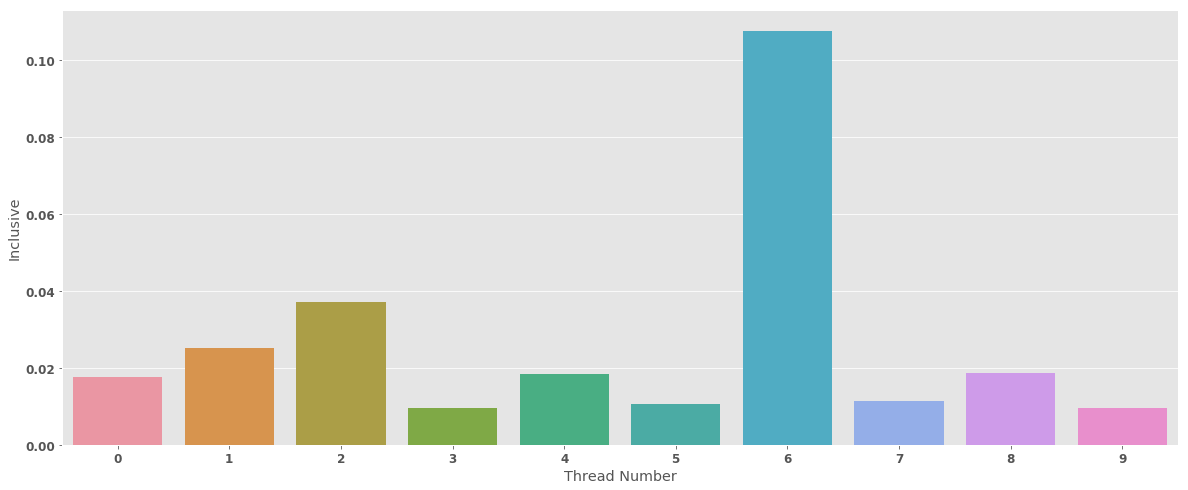

In [19]:
add_L1_missrate(expr_intervals)   # DERIVED_L1_MISSRATE
L1mr_fun, g = plot_metric(expr_intervals,'DERIVED_L1_MISSRATE',function="MkFinder::SelectHitIndices",percent=True)
L1mr_fun['Inclusive'].head(10)

In [20]:
add_CPI(expr_intervals)
print(expr_intervals.keys())

expr_intervals['DERIVED_CPI'].head(10)

['PAPI_NATIVE_UOPS_RETIRED:SCALAR_SIMD', 'PAPI_L2_TCA', 'PAPI_NATIVE_LLC_MISSES', 'DERIVED_CPI', 'DERIVED_VIPC', 'DERIVED_L1_MISSRATE', 'PAPI_RES_STL', 'PAPI_L2_TCM', 'PAPI_TOT_INS', 'PAPI_NATIVE_UOPS_RETIRED:PACKED_SIMD', 'DERIVED_IPC', 'PAPI_LST_INS', 'METADATA', 'PAPI_L1_TCM', 'PAPI_TOT_CYC', 'PAPI_NATIVE_LLC_REFERENCES']


Calls  \
context thread region                                                         
0       0      [SUMMARY] (anonymous namespace)::MultHelixProp(... 1.000e+00   
               [SUMMARY] (anonymous namespace)::MultHelixPropE... 1.000e+00   
               [SUMMARY] (anonymous namespace)::MultHelixPropT... 2.000e+00   
               [SUMMARY] Event::clean_cms_seedtracks()            8.621e-01   
               [SUMMARY] FMA(__m256 const&, __m256 const&, __m... 3.000e+00   
               [SUMMARY] Hit::Hit()                               1.000e+00   
               [SUMMARY] HitOnTrack::HitOnTrack()                 1.500e+00   
               [SUMMARY] Matriplex::Matriplex<int, 1, 1, 8>::o... 1.000e+00   
               [SUMMARY] Matriplex::MatriplexSym<float, 3, 8>:... 1.000e+00   
               [SUMMARY] Matriplex::MatriplexSym<float, 6, 8>:... 6.667e-01   

                                                                   Exclusive  \
context thread region                                                          
0       0      [SUMMARY] (anonymous namespace)::MultHelixProp(...  1.531e+00   
               [SUMMARY] (anonymous namespace)::MultHelixPropE...  2.296e+00   
               [SUMMARY] (anonymous namespace)::MultHelixPropT...  2.747e+00   
               [SUMMARY] Event::clean_cms_seedtracks()             1.410e+00   
               [SUMMARY] FMA(__m256 const&, __m256 const&, __m...  9.215e+00   
               [SUMMARY] Hit::Hit()                                1.554e+00   
               [SUMMARY] HitOnTrack::HitOnTrack()                  2.085e+00   
               [SUMMARY] Matriplex::Matriplex<int, 1, 1, 8>::o...  1.863e+00   
               [SUMMARY] Matriplex::MatriplexSym<float, 3, 8>:...  1.482e+00   
               [SUMMARY] Matriplex::MatriplexSym<float, 6, 8>:...  9.454e-01   

                                                                   Inclusive  \
context thread region                                                          
0       0      [SUMMARY] (anonymous namespace)::MultHelixProp(...  1.531e+00   
               [SUMMARY] (anonymous namespace)::MultHelixPropE...  2.296e+00   
               [SUMMARY] (anonymous namespace)::MultHelixPropT...  2.747e+00   
               [SUMMARY] Event::clean_cms_seedtracks()             1.410e+00   
               [SUMMARY] FMA(__m256 const&, __m256 const&, __m...  9.215e+00   
               [SUMMARY] Hit::Hit()                                1.554e+00   
               [SUMMARY] HitOnTrack::HitOnTrack()                  2.085e+00   
               [SUMMARY] Matriplex::Matriplex<int, 1, 1, 8>::o...  1.863e+00   
               [SUMMARY] Matriplex::MatriplexSym<float, 3, 8>:...  1.482e+00   
               [SUMMARY] Matriplex::MatriplexSym<float, 6, 8>:...  9.454e-01   

                                                                   ProfileCalls  \
context thread region                                                             
0       0      [SUMMARY] (anonymous namespace)::MultHelixProp(...           nan   
               [SUMMARY] (anonymous namespace)::MultHelixPropE...           nan   
               [SUMMARY] (anonymous namespace)::MultHelixPropT...           nan   
               [SUMMARY] Event::clean_cms_seedtracks()                      nan   
               [SUMMARY] FMA(__m256 const&, __m256 const&, __m...           nan   
               [SUMMARY] Hit::Hit()                                         nan   
               [SUMMARY] HitOnTrack::HitOnTrack()                           nan   
               [SUMMARY] Matriplex::Matriplex<int, 1, 1, 8>::o...           nan   
               [SUMMARY] Matriplex::MatriplexSym<float, 3, 8>:...           nan   
               [SUMMARY] Matriplex::MatriplexSym<float, 6, 8>:...           nan   

                                                                   Subcalls  
context thread region                                                        
0       0      [SUMMARY] (anonymous namespace)

### Metric Generation

gen_metric generates the boring bits of the metric adding function
* List the metrics you will use
* provide a name for the new metric
* paste into metrics.py
* implement the math bit

In [21]:
print(gen_metric(['PAPI_NATIVE_UOPS_RETIRED_PACKED_SIMD', 'PAPI_L1_TCM', "MORE"], "VECTOR_PER_MISS"))

def add_VECTOR_PER_MISS(metrics):
	if (not metrics.has_key(PAPI_NATIVE_UOPS_RETIRED_PACKED_SIMD)):
		print 'ERROR adding VECTOR_PER_MISS to metric dictionary'
		return False	a0 = metrics[PAPI_NATIVE_UOPS_RETIRED_PACKED_SIMD].copy()
	a0.index = a0.index.droplevel()
	u0 = a0.unstack()
	if (not metrics.has_key(PAPI_L1_TCM)):
		print 'ERROR adding VECTOR_PER_MISS to metric dictionary'
		return False	a1 = metrics[PAPI_L1_TCM].copy()
	a1.index = a1.index.droplevel()
	u1 = a1.unstack()
	if (not metrics.has_key(MORE)):
		print 'ERROR adding VECTOR_PER_MISS to metric dictionary'
		return False	a2 = metrics[MORE].copy()
	a2.index = a2.index.droplevel()
	u2 = a2.unstack()
	metrics[VECTOR_PER_MISS] = "PLEASE IMPLEMENT THIS PART"

	return True





## Interesting bits

This is where the stuff is actually calculated.

In [22]:
# levels: 0=trial, 1=node, 2=context, 3=thread, 4=region name -- deprecated
# levels: 0=rank, 1=context, 2=thread, 3=region name -- deprecated

       
n=10

def get_hotspots(metric):
    print('selected metric: %s\n' %metric)
    hotspots(expr_intervals[metric], n, 1)

    print('='*80)

    filtered_dfs = filter_libs_out(expr_intervals[metric])
    hotspots(filtered_dfs, n, 1)
    
get_hotspots('PAPI_TOT_CYC')



selected metric: PAPI_TOT_CYC

Hotspot Analysis Summary
The code regions with largest inclusive time are: 
1: [SUMMARY] _int_free  (1231159555)
2: [SUMMARY] _int_malloc  (1219269406)
3: [SUMMARY] __GI___libc_malloc  (1202496560)
4: [SUMMARY] Event::clean_cms_seedtracks()  (1112271578)
5: [SUMMARY] UNRESOLVED /storage/packages/intel/vtune_amplifier_xe_2017.5.0.526192/lib64/libstdc++.so.6.0.20 (881792500)
6: [SUMMARY] __intel_mic_avx512f_memset  (657456121)
7: [SUMMARY] malloc_consolidate  (627882012)
8: [SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)  (503503986)
9: [SUMMARY] __svml_sincosf8_l9  (332896727)
10: [SUMMARY] __GI___libc_free  (330621773)
Hotspot Analysis Summary
The code regions with largest inclusive time are: 
1: [SUMMARY] _int_free  (1231159555)
2: [SUMMARY] _int_malloc  (1219269406)
3: [SUMMARY] __GI___libc_malloc  (1202496560)
4: [SUMMARY] Event::clean_cms_seedtracks()  (1112271578)
5: [SUMMARY] UNRESOLVED /storage/packages/intel/vtune_amplifier_xe_2017.5

In [23]:
get_hotspots('DERIVED_CPI')

selected metric: DERIVED_CPI

Hotspot Analysis Summary
The code regions with largest inclusive time are: 
1: [SUMMARY] __GI___sched_yield  (1383.3555433316772)
2: [SUMMARY] Matriplex::Matriplex<float, 6, 1, 8>::CopyOut(int, float*) const  (337.8687114599183)
3: [SUMMARY] FMA(__m256 const&, __m256 const&, __m256 const&)  (143.3827012750045)
4: [SUMMARY] helixAtRFromIterativeCCS(Matriplex::Matriplex<float, 6, 1, 8> const&, Matriplex::Matriplex<int, 1, 1, 8> const&, Matriplex::Matriplex<float, 6, 1, 8>&, Matriplex::Matriplex<float, 1, 1, 8> const&, Matriplex::Matriplex<float, 6, 6, 8>&, int, bool)  (140.12204158515513)
5: [SUMMARY] (anonymous namespace)::MultHelixPropEndcap(Matriplex::Matriplex<float, 6, 6, 8> const&, Matriplex::MatriplexSym<float, 6, 8> const&, Matriplex::Matriplex<float, 6, 6, 8>&)  (33.74236172284297)
6: [SUMMARY] Matriplex::MatriplexSym<float, 6, 8>::CopyIn(int, float const*)  (30.655652580671333)
7: [SUMMARY] Matriplex::MatriplexSym<float, 3, 8>::CopyIn(int, float co

In [24]:
add_L1_missrate(expr_intervals)
get_hotspots('DERIVED_L1_MISSRATE')

selected metric: DERIVED_L1_MISSRATE

Hotspot Analysis Summary
The code regions with largest inclusive time are: 
1: [SUMMARY] Matriplex::Matriplex<float, 6, 1, 8>::CopyIn(int, float const*)  (7.959092527266255)
2: [SUMMARY] helixAtZ(Matriplex::Matriplex<float, 6, 1, 8> const&, Matriplex::Matriplex<int, 1, 1, 8> const&, Matriplex::Matriplex<float, 6, 1, 8>&, Matriplex::Matriplex<float, 1, 1, 8> const&, Matriplex::Matriplex<float, 6, 6, 8>&, int, bool)  (0.5107799008849265)
3: [SUMMARY] __libm_atan2f_l9  (0.46327701325977244)
4: [SUMMARY] Matriplex::MatriplexSym<float, 6, 8>::CopyOut(int, float*) const  (0.41195697268666387)
5: [SUMMARY] Matriplex::MatriplexSym<float, 6, 8>::operator=(Matriplex::MatriplexSym<float, 6, 8> const&)  (0.39198551753212324)
6: [SUMMARY] __intel_mic_avx512f_memset  (0.18926064216945399)
7: [SUMMARY] propagateHelixToZMPlex(Matriplex::MatriplexSym<float, 6, 8> const&, Matriplex::Matriplex<float, 6, 1, 8> const&, Matriplex::Matriplex<int, 1, 1, 8> const&, float, 

In [25]:
get_hotspots('PAPI_NATIVE_UOPS_RETIRED:SCALAR_SIMD')

selected metric: PAPI_NATIVE_UOPS_RETIRED:SCALAR_SIMD

Hotspot Analysis Summary
The code regions with largest inclusive time are: 
1: [SUMMARY] Event::clean_cms_seedtracks()  (45303950)
2: [SUMMARY] _int_malloc  (37464340)
3: [SUMMARY] __GI___libc_malloc  (25576302)
4: [SUMMARY] UNRESOLVED /storage/packages/intel/vtune_amplifier_xe_2017.5.0.526192/lib64/libstdc++.so.6.0.20 (11175639)
5: [SUMMARY] __intel_mic_avx512f_memset  (7617833)
6: [SUMMARY] __libm_sse2_sincosf  (5309597)
7: [SUMMARY] __GI___sched_yield  (4650564)
8: [SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)  (4344792)
9: [SUMMARY] __svml_sincosf8_l9  (3547083)
10: [SUMMARY] _int_free  (3489947)
Hotspot Analysis Summary
The code regions with largest inclusive time are: 
1: [SUMMARY] Event::clean_cms_seedtracks()  (45303950)
2: [SUMMARY] _int_malloc  (37464340)
3: [SUMMARY] __GI___libc_malloc  (25576302)
4: [SUMMARY] UNRESOLVED /storage/packages/intel/vtune_amplifier_xe_2017.5.0.526192/lib64/libstdc++.so.6.0.20 